In [1]:
#https://www.kaggle.com/piotrstanczyk/gfootball-template-bot  G-FOOTBALL TEMPLATE BOT
# Install:
# Kaggle environments.
!git clone https://github.com/Kaggle/kaggle-environments.git
!cd kaggle-environments && pip install .

# GFootball environment.
!apt-get update -y
!apt-get install -y libsdl2-gfx-dev libsdl2-ttf-dev

# Make sure that the Branch in git clone and in wget call matches !!
!git clone -b v2.8 https://github.com/google-research/football.git
!mkdir -p football/third_party/gfootball_engine/lib

!wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.8.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install .

!pip install utils
#!pip install learning

Cloning into 'kaggle-environments'...
remote: Enumerating objects: 4311, done.
remote: Counting objects: 100% (1091/1091), done.
remote: Compressing objects: 100% (316/316), done.
remote: Total 4311 (delta 871), reused 926 (delta 773), pack-reused 3220
Receiving objects: 100% (4311/4311), 11.00 MiB | 13.19 MiB/s, done.
Resolving deltas: 100% (2628/2628), done.
Processing /content/kaggle-environments
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 63 kB 1.2 MB/s 
  Created wheel for kaggle-environments: filename=kaggle_environments-1.9.9-py3-none-any.whl size=1820377 sha256=a7c6b3517a9c1b7a417f342c384d168f

In [2]:
#from gfootball.env.football_env import FootballEnv
from kaggle_environments import make
from gfootball.env.config import Config
import gfootball.env as football_env

#import dqn libraries
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import numpy as np
import pandas as pd
import itertools
import utils
import random
from collections import deque
import matplotlib.pyplot as plt
#from utils import plot_learning_curve
#import env 
import gym
import gfootball 
import math

#env_name = "GFootballBase-v0"
#print(env_name)

In [3]:
class DeepQNetwork(nn.Module):
  def __init__(self,lr,input_dims,fc1_dims,fc2_dims,fc3_dims,n_actions):
    super(DeepQNetwork,self).__init__()
   # self.lr=lr
    self.input_dims=input_dims
    self.fc1_dims=fc1_dims
    self.fc2_dims=fc2_dims
    self.fc3_dims=fc3_dims
    self.n_actions=n_actions
    
    self.fc1=nn.Linear(*self.input_dims,self.fc1_dims) #pass list of observations as input
    self.fc2=nn.Linear(self.fc1_dims,self.fc2_dims)
    self.fc3=nn.Linear(self.fc2_dims,self.fc3_dims)
    self.fc3=nn.Linear(self.fc3_dims,self.n_actions) #output number action

    self.optimizer = optim.Adam(self.parameters(),lr=lr)
    self.loss=nn.MSELoss()
    self.device =T.device('cuda:0' if T.cuda.is_available() else 'cpu' )
    self.to(self.device)

  def forward(self,state):
   
    x=F.relu(self.fc1(state))
    x=F.relu(self.fc2(x))
    actions=self.fc3(x)
      
    return actions


In [6]:
class All_prints():
  
  def __init___(self,step):
    self.step=step
    #self.RewBuffer = RewBuffer
    self.reward=reward

  def printstats(self,step,rew_list,eps_reward,epsilon):  #Kaleitai otan ginei done , diladi otan teleiosei ena paixnidi
    self.step=step
    self.rew_list=rew_list
    self.eps_reward=eps_reward
    self.epsilon=epsilon
    print("-->Episode:",i%3000 + 1,"\t","Episode Reward:",eps_reward,"\t Epsilon",agent.epsilon,"<--")
    #print("Step",step)
    print("lista apo rewards mexri tora" ,self.rew_list)
    print("Avg reward", np.mean(self.rew_list))
    print("---------------------------------------------------")

  def print_who_scored(self, reward):
    self.reward=reward
    if(self.reward==1):
      print("our team scored !!!")
    elif(self.reward ==-1):
      print("opponent team scored")
    
    
 
  def rew_graph(self,rew_list,num_of_eps):
      self.rew_list=rew_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.rew_list)
      plt.xlabel('Episode')
      plt.ylabel('Rewards')
      plt.grid(True)
      plt.show()


  def score_graph(self,score_list,num_of_eps):
      self.score_list=score_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.score_list)
      plt.xlabel('Episode')
      plt.ylabel('Score')
      plt.grid(True)
      plt.show()

In [10]:
class Agent():
  def __init__(self,gamma,epsilon, lr , input_dims , batch_size ,n_actions, max_mem_size = 40000  , eps_end=0.01 , eps_dec = 5e-4):
    self.gamma=gamma
    self.epsilon =epsilon
    self.lr=lr
    self.eps_min=eps_end
    self.eps_dec=eps_dec
   
    self.action_space =[i for i in range(n_actions)]
    self.mem_size = max_mem_size
    self.batch_size = batch_size
    self.n_actions=n_actions
    self.mem_cntr =0 # keep track of the position of first available memory 

    self.Q_eval = DeepQNetwork(self.lr,n_actions=n_actions,input_dims= input_dims, fc1_dims=600, fc2_dims=600 , fc3_dims=600)

    self.state_memory = np.zeros((self.mem_size,*input_dims),dtype =np.float32)
    self.new_state_memory= np.zeros((self.mem_size , *input_dims),dtype=np.float32)

    self.action_memory=np.zeros(self.mem_size , dtype=np.int32) #discrete actions (19)
    self.reward_memory=np.zeros(self.mem_size,dtype= np.float32)
    self.terminal_memory= np.zeros(self.mem_size,dtype=bool)


  def store_transition(self,state,action,reward,new_state , done ):
    index = self.mem_cntr% self.mem_size

    self.state_memory[index]= state
    self.new_state_memory[index]= new_state
    self.reward_memory[index]= reward
    self.action_memory[index]= action  #which action is taken 
    self.terminal_memory[index]= done

    self.mem_cntr +=1
    

  def choose_action(self,observation):
    if np.random.random()> self.epsilon:
      
      state =T.tensor([observation]).to(self.Q_eval.device) #turn observation to tensor and send it to device for computations
      action_list = self.Q_eval.forward(state) #returns the values of each action
      action = T.argmax(action_list).item()
      #print("exploit:",action)
    else:     #
      
      action = np.random.choice(self.action_space)
      #print("explore:",action)
    return action

  def learn(self):    #fill batch size then learn 
    if self.mem_cntr < self.batch_size :
      return
    
    
    self.Q_eval.optimizer.zero_grad()

    #calculate the position of max memory / extract subset of max memories
    max_mem =min(self.mem_cntr , self.mem_size)
    for i in range(self.mem_size//self.batch_size):
      #batch=np.random.choice(max_mem,self.batch_size,replace=False) #We dont keep selecting the same memories more than once
     
      batch = np.random.permutation(max_mem)[:self.batch_size]
      #mem = np.array(exp_buffer)[perm_batch]

      #batch=np.random.choice(max_mem,self.batch_size,replace=False)
      batch_index = np.arange(self.batch_size , dtype=np.int32)

      state_batch=T.tensor(self.state_memory[batch]).to(self.Q_eval.device) #make numpy array a pytorch tensor
      new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
      reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
      terminal_batch= T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

      action_batch = self.action_memory[batch] 
    
      q_eval = self.Q_eval.forward(state_batch)[batch_index,action_batch] #EXEI THEMA
      q_next = self.Q_eval.forward(new_state_batch)

      q_next[terminal_batch] = 0.0
      q_target = reward_batch +self.gamma * T.max(q_next,dim=1)[0] #max value of next state

      loss = self.Q_eval.loss(q_target,q_eval).to(self.Q_eval.device)
      loss.backward()
      self.Q_eval.optimizer.step()

      self.epsilon = self.epsilon - self.eps_dec if (self.epsilon > self.eps_min)  else self.eps_min
      

shout entos periohis episode 0 step= 71
ball is out -10 episode 0 step= 74
---Avg reward last: -13.766991726921173 Avg score last 0.0 Avg steps 75.0 episode= 0 ---
ball is out -10 episode 1 step= 44
goal episode 2 step= 74
shout entos periohis episode 3 step= 83
shout entos periohis episode 3 step= 85
goal episode 3 step= 103
goal episode 4 step= 90
goal episode 5 step= 109
goal episode 6 step= 108
shout entos periohis episode 7 step= 83
goal episode 7 step= 90
goal episode 8 step= 110
goal episode 9 step= 108
goal episode 10 step= 108
---Avg reward last: 3.2630904402661507 Avg score last 0.9 Avg steps 95.4 episode= 10 ---
goal episode 11 step= 109
goal episode 12 step= 110
goal episode 13 step= 110
goal episode 14 step= 108
shout entos periohis episode 15 step= 89
goal episode 15 step= 95
shout entos periohis episode 16 step= 74
goal episode 16 step= 85
goal episode 17 step= 109
goal episode 18 step= 110
goal episode 19 step= 108
goal episode 20 step= 108
---Avg reward last: 5.1033357

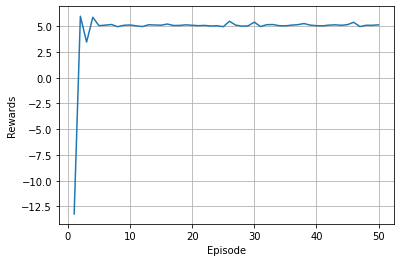

goal episode 51 step= 109
goal episode 52 step= 108
goal episode 53 step= 109
goal episode 54 step= 108
goal episode 55 step= 108
goal episode 56 step= 109
goal episode 57 step= 108
goal episode 58 step= 109
goal episode 59 step= 108
goal episode 60 step= 108
---Avg reward last: 5.0841917662213 Avg score last 1.0 Avg steps 109.4 episode= 60 ---
goal episode 61 step= 108
goal episode 62 step= 108
goal episode 63 step= 108
goal episode 64 step= 109
goal episode 65 step= 109
goal episode 66 step= 112
goal episode 67 step= 109
goal episode 68 step= 110
goal episode 69 step= 108
shout entos periohis episode 70 step= 83
goal episode 70 step= 90
---Avg reward last: 5.068714961252463 Avg score last 1.0 Avg steps 108.1 episode= 70 ---
goal episode 71 step= 109
goal episode 72 step= 110
goal episode 73 step= 109
shout entos periohis episode 74 step= 75
goal episode 74 step= 84
goal episode 75 step= 109
goal episode 76 step= 109
goal episode 77 step= 109
goal episode 78 step= 110
goal episode 79 

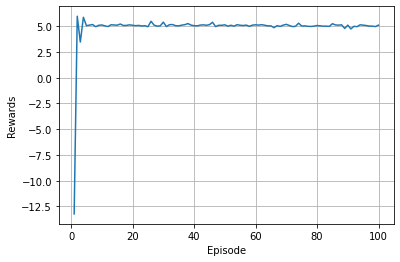

goal episode 101 step= 109
shout entos periohis episode 102 step= 93
goal episode 102 step= 98
shout entos periohis episode 103 step= 83
goal episode 103 step= 90
goal episode 104 step= 108
shout entos periohis episode 105 step= 57
goal episode 105 step= 74
goal episode 106 step= 109
goal episode 107 step= 108
goal episode 108 step= 110
goal episode 109 step= 110
goal episode 110 step= 108
---Avg reward last: 5.10704177860087 Avg score last 1.0 Avg steps 103.4 episode= 110 ---
goal episode 111 step= 108
goal episode 112 step= 111
shout entos periohis episode 113 step= 83
goal episode 113 step= 90
goal episode 114 step= 111
goal episode 115 step= 109
shout entos periohis episode 116 step= 101
goal episode 116 step= 104
goal episode 117 step= 108
goal episode 118 step= 109
goal episode 119 step= 109
goal episode 120 step= 108
---Avg reward last: 5.064986047407887 Avg score last 1.0 Avg steps 107.7 episode= 120 ---
goal episode 121 step= 108
shout entos periohis episode 121 step= 108
goal

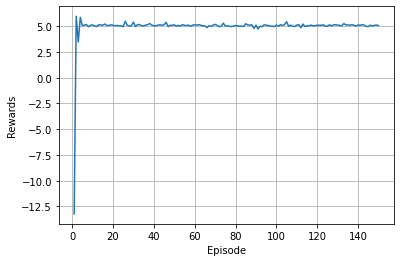

goal episode 151 step= 109
goal episode 152 step= 108
goal episode 153 step= 109
goal episode 154 step= 109
goal episode 155 step= 110
shout entos periohis episode 156 step= 64
goal episode 156 step= 76
goal episode 157 step= 109
goal episode 158 step= 108
goal episode 159 step= 108
goal episode 160 step= 108
---Avg reward last: 5.115533390358015 Avg score last 1.0 Avg steps 106.4 episode= 160 ---
goal episode 161 step= 110
shout entos periohis episode 162 step= 103
goal episode 162 step= 107
goal episode 163 step= 108
goal episode 164 step= 109
goal episode 165 step= 108
shout entos periohis episode 166 step= 83
goal episode 166 step= 90
goal episode 167 step= 110
goal episode 168 step= 108
shout entos periohis episode 169 step= 73
shout entos periohis episode 169 step= 76
goal episode 169 step= 82
goal episode 170 step= 109
---Avg reward last: 5.077043521401155 Avg score last 1.0 Avg steps 105.1 episode= 170 ---
goal episode 171 step= 110
goal episode 172 step= 109
goal episode 173 s

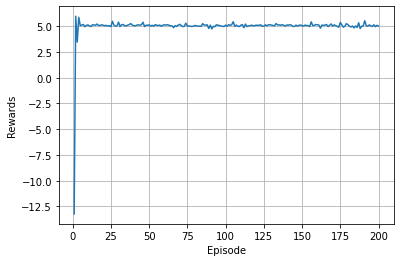

goal episode 201 step= 109
goal episode 202 step= 109
goal episode 203 step= 109
shout entos periohis episode 204 step= 61
goal episode 204 step= 74
goal episode 205 step= 112
goal episode 206 step= 109
goal episode 207 step= 108
goal episode 208 step= 108
goal episode 209 step= 109
shout entos periohis episode 210 step= 75
goal episode 210 step= 84
---Avg reward last: 5.126147989032814 Avg score last 1.0 Avg steps 104.1 episode= 210 ---
shout entos periohis episode 211 step= 81
goal episode 211 step= 89
goal episode 212 step= 109
goal episode 213 step= 114
goal episode 214 step= 108
goal episode 215 step= 109
goal episode 216 step= 111


In [ ]:

#if __name__ == '__main__':
#env = football_env.create_environment(env_name ='11_vs_11_easy_stochastic',render=False,representation='simple115')  #List with the 115 states 
env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')  #List with the 115 states 
#env = gym.make("GFootball-11_vs_11_kaggle-simple115v2-v0") #List with the 115 states
#env = football_env.create_environment(env_name ='academy_single_goal_versus_lazy',render=False,representation='simple115')
#env = football_env.create_environment(env_name ='academy_pass_and_shoot_with_keeper',render=False,representation='simple115')
#env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115')  #List with the 115 states 

#CUSTOMIZE ACTION LIST AND OBSERVATIONS
Action_list=[4,5,6,12]

#Create Objects

agent = Agent(gamma=0.99,epsilon=1.0 ,batch_size = 200 ,lr=0.00015 ,input_dims= [115], n_actions = len(Action_list) )# batch = best 256
all_prints = All_prints()
#cus_rew =Custom_Rewards()

scores,ep_history =[],[]

steps=0
terminal =0
episode =0



num_of_eps = 1000
eps_rew=0
rew_list =[]
score_list = []
step_list =[]
for i in range(num_of_eps) : 
  score =0 
  done=False 
  observation =env.reset()
  act =0 #first action will be to move right 
  while not done:

    #CUSTOMIZE ACTIONS HERE 
    #An einai i mpala sto 0.5 kai exo katoxi kane shout diladi action 12
    
    #print("------------")
    #print("Ball X-Y-Z Axis",observation[88],observation[89],observation[90],"||","direct",observation[91],observation[92],observation[93],"Katoxi",observation[95],observation[96])
    #print("Player X-Axis Y-Axis",observation[2],observation[3] ,"episode",i)
    #print("------------")

    #na bazei goal aytomata
    #if(observation[2]>0.6 and observation[95] == 1):
      
      
      #print("EXO MPALA",12)
      #new_observation,reward,done,info = env.step(12) #kanei shout Action 12

      #print("ball position",observation[88], "Action taken", action)
     
      
 
    if(act ==0 ):
      
      # print("action 5",Action_list[action])
      new_observation,reward,done,info = env.step(5)
      act=1
    #print("Sto Else",observation[94],observation[95],observation[96])
    

    
    action = agent.choose_action(observation)
    while((observation[2]<0.5) and (observation[95] == 1) and (Action_list[action]==12)):
      action = agent.choose_action(observation)

    new_observation,reward,done,info = env.step(Action_list[action])

    #if(reward!=1):  #each step loses -0.2
      #reward= reward -0.2
    
    

    if(done ==1 and reward !=1): #if ball is out ,loses -2
      reward = reward -10
      print("ball is out -10","episode",i,"step=",steps)
    if(reward==1 and  done ==1): #if agent scores , wins +5
      print("goal","episode",i,"step=",steps)
      reward = 10


    if((observation[2]<0.5) and (observation[95] == 1) and (Action_list[action]==12)): #an shoutarei prin th megali perioxh -2
      
      reward= reward -200
      done=1
      print("shout ektos periohis","episode",i,"step=",steps)

    if((observation[2]>0.5) and (observation[95] == 1) and (Action_list[action]==12)): #an shoutarei mesa ti megali periohi +0.1
      #reward= reward +0.1
      print("shout entos periohis","episode",i,"step=",steps)
      
    reward = reward - ( math.sqrt( ((0.935 - observation[2])**2) + (0 -observation[3])**2 ) *0.1) #oso pio makria einai toso perissotero xanei
    #print("Den exo mpala",Action_list[action])
    #print("DEN EXO MPALA",Action_list[action],action)

    #custom reward here
 
    
    #if( ((observation[88]>0.99) and (observation[95]==1)) or  ((observation[89]>0.39) and (observation[95]==1)) or ((observation[89] < -0.39)and(observation[95]==1)) ):
      #reward =-2
      #print("bgike ektos")
    #if((reward!=1) or (reward!=-1)):
      #reward =cus_rew.custom_rew(observation,action,reward,new_observation)
    score= +reward

    #for prints
    eps_rew+=reward
    #all_prints.print_who_scored(reward)
    

    agent.store_transition(observation,action,reward,new_observation,done)
    agent.learn()
    observation = new_observation

    scores.append(score)
    ep_history.append(agent.epsilon)

    avg_score= np.mean(scores)


    steps=steps+1
    
#---- BE CAREFUL OF THE WHILE !!! HERE IS EPIDOSE ENDING--------
  #print("Reward",eps_rew,"Episode",i,"Steps" , steps)
  step_list.append(steps)
  steps=0

  val = info.values()
  list_val=list(val)
  score_list.append(list_val)
  
  #terminate if 500 episodes are correct 
  if(eps_rew == 1 ):
    terminal= terminal +1
    if(terminal == 500):
      print("500 Episodes with goal")
      break
  else:
      terminal =0 
  episode = episode +1 
  

  rew_list.append(eps_rew)

# PRINTS
  if (i % 10)== 0 :
      print("---Avg reward last:", np.mean(rew_list[-10:]),"Avg score last",np.mean(score_list[-10:]),"Avg steps",np.mean(step_list[-10:]),"episode=",i,"---")
      #print(score_list)

  if (((i % 1000)== 0) and i!=0) :
      all_prints.score_graph(score_list[-1000:],1000)# graph the last 1000 episodes
  if(((i%50)==0) and i!=0):
    all_prints.rew_graph(rew_list[-i:],i)
     
  
  #EPISODE PRINTS
  #all_prints.printstats(i,rew_list,eps_rew,agent.epsilon)
  
  eps_rew=0



print("Avg score last:", np.mean(rew_list[-10:]),"Avg score",np.mean(score_list),"Avg steps",np.mean(step_list[-10:]),"episode=",i)
all_prints.score_graph(score_list[-1000:],1000)# graph the last 1000 episodes
      
#all_prints.score_graph(score_list,i+1)#i = num_of_eps
#print("\n ")
#all_prints.rew_graph(rew_list,i+1)


In [ ]:
#plot step_list plt.plot(step_list)

In [ ]:
class Custom_Rewards():
  #def __init__(self):
    #self.obs=obs    
    #self.action=action
    #self.reward =reward
  def custom_rew(self,obs,action,reward,new_obs):
    
    self.obs=obs
    self.action = action
    self.reward = reward
    self.new_obs=new_obs
    
    
#if the next action is shooting the ball, the reward will gain 0.2 point ||
#an exo ti mpala kai einai se apostasi x > 0.5 sto gipedo kai exei kanei shout einai kalo    
    if(self.obs[95] == 1 and self.obs[88] > 0.6 and self.action == 12):
      self.reward += 0.02
      #print("EKANE SHOUT MPROSTA APO TO KENTRO ,+0.1")
      return self.reward

    #An kanei shout piso apo to kentro na xanei ligo
    elif(self.obs[95]==1 and self.obs[88] < 0 and self.action == 12):
      self.reward -= 0.02
      #print("EKANE SHOUT PISO APO TO KENTRO, -0.05")
      return self.reward

# if we steal the ball, the reward will gain 0.05 points
    elif self.obs[96] == 1 and self.new_obs[95] == 1:  #obs[96] ball owner right team / obs[95] ball owner left team
        self.reward += 0.05
        #print("PHRE THN MPALA APO TON ANTIPALO , +0.05")
        return self.reward
#if we lose the ball, the reward will lose 0.05 points
    elif self.obs[95] == 1 and self.new_obs[96] == 1:
        self.reward -=0.02
        #print("PHRE THN MPALA O ANTIPALOS , -0.02")
        return self.reward
    else:
      return self.reward


#TODO: if active player far from the ball, the reward will lose by the moving distance

In [ ]:
#print(score_list or reward_list)

In [ ]:

"""print(observation)
new_observation,reward,done,info = env.step(4)
print(new_observation)"""

'print(observation)\nnew_observation,reward,done,info = env.step(4)\nprint(new_observation)'

In [ ]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

In [ ]:
"""env = football_env.create_environment(env_name ='academy_single_goal_versus_lazy',render=False,representation='simple115')
observation =env.reset()
new_observation,reward,done,info = env.step(action)
val=info.values()
print(val)
list_val=list(val)
list_val"""